# CHIPS-CVN Classification Notebook

In [1]:
import chipscvn.utils as utils
import chipscvn.config as config
import chipscvn.data as data
import chipscvn.models as models
import chipscvn.evaluators as evaluators
utils.gpu_setup()  # Setup the GPU's

---  3 Physical GPUs, 3 Logical GPUs ---


Load the trained model from the configuration, run the classification evaluator and print the columns in the Pandas DataFrame.

In [2]:
conf = config.get("config/classification.yml")
config.setup_dirs(conf, False)
evaluator = utils.get_evaluator(conf)
evaluator.run()
print(evaluator.events.columns)

--- Running Evaluation ---

--- 60.52965521812439 seconds to test model ---
Index(['true_pdg', 'true_type', 'true_category', 'true_vtxX', 'true_vtxY',
       'true_vtxZ', 'true_dirTheta', 'true_dirPhi', 'true_nuEnergy',
       'true_lepEnergy', 'raw_num_hits', 'filtered_num_hits',
       'num_hough_rings', 'raw_total_digi_q', 'filtered_total_digi_q',
       'first_ring_height', 'last_ring_height', 'reco_vtxX', 'reco_vtxY',
       'reco_vtxZ', 'reco_dirTheta', 'reco_dirPhi', 'predictions',
       'dense_output', 'ct_image', 'h_image'],
      dtype='object')


Classify the events into the 4 different categories and calculate the combined values...

In [3]:
import numpy as np

def pred_classifier(row):
    combined_values = [
        row["predictions"][0]+row["predictions"][2]+row["predictions"][4]+row["predictions"][6],
        row["predictions"][1]+row["predictions"][3]+row["predictions"][5]+row["predictions"][7],
        row["predictions"][8],
        row["predictions"][9]
    ]
    return np.asarray(combined_values).argmax()
        
def true_classifier(row):
    if row["true_category"] in [0,2,4,6]:
        return 0
    elif row["true_category"] in [1,3,5,7]:
        return 1
    elif row["true_category"] == 8:
        return 2
    elif row["true_category"] == 9:
        return 3
    
def pred_0(row):
    return row["predictions"][0]+row["predictions"][2]+row["predictions"][4]+row["predictions"][6]

def pred_1(row):
    return row["predictions"][1]+row["predictions"][3]+row["predictions"][5]+row["predictions"][7]

def pred_2(row):
    return row["predictions"][8]

def pred_3(row):
    return row["predictions"][9]

evaluator.events['true_cat_combined'] = evaluator.events.apply(true_classifier, axis=1)
evaluator.events['pred_cat_combined'] = evaluator.events.apply(pred_classifier, axis=1)
evaluator.events["true_cat_combined"] = evaluator.events["true_cat_combined"].astype('int')
evaluator.events["true_cat_combined"] = evaluator.events["true_cat_combined"].astype('int')

evaluator.events['pred_0'] = evaluator.events.apply(pred_0, axis=1)
evaluator.events['pred_1'] = evaluator.events.apply(pred_1, axis=1)
evaluator.events['pred_2'] = evaluator.events.apply(pred_2, axis=1)
evaluator.events['pred_3'] = evaluator.events.apply(pred_3, axis=1)

<Figure size 1152x720 with 0 Axes>

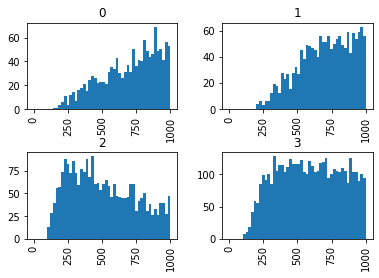

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,10))
evaluator.events.hist(column='raw_total_digi_q', by='true_cat_combined', bins=50, range=[0,1000])
plt.show()

<Figure size 1152x720 with 0 Axes>

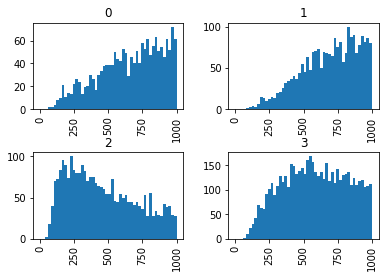

In [5]:
plt.figure(figsize=(16,10))
evaluator.events.hist(column='first_ring_height', by='true_cat_combined', bins=50, range=[0,1000])
plt.show()

<Figure size 1152x720 with 0 Axes>

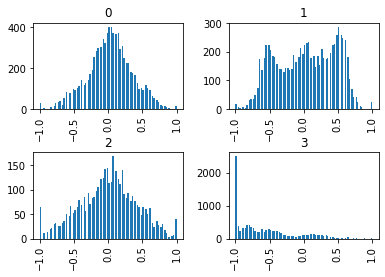

In [6]:
plt.figure(figsize=(16,10))
evaluator.events.hist(column='reco_dirTheta', by='true_cat_combined', bins=100, range=[-1,1])
plt.show()

<Figure size 1152x720 with 0 Axes>

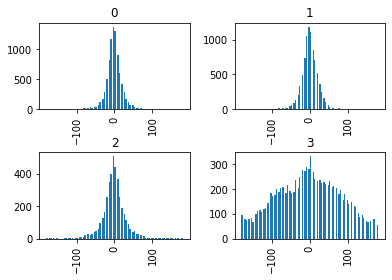

In [7]:
plt.figure(figsize=(16,10))
evaluator.events.hist(column='reco_dirPhi', by='true_cat_combined', bins=100, range=[-180,180])
plt.show()

In [13]:
print(evaluator.events.size)
selection = evaluator.events[(evaluator.events["raw_total_digi_q"] >= 250.0)]
print(selection.size)
selection = selection[(selection["first_ring_height"] >= 250.0)]
print(selection.size)
selection = selection[(selection["reco_dirTheta"] >= -0.75)]
print(selection.size)
selection = selection[(selection["reco_dirTheta"] <= 0.75)]
print(selection.size)
selection = selection[(selection["reco_dirPhi"] <= 50)]
print(selection.size)
selection = selection[(selection["reco_dirPhi"] <= 50)]
print(selection.size)

1024000
999904
977760
818592
810656
755936
755936


<Figure size 1152x720 with 0 Axes>

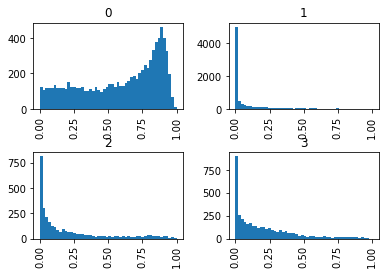

In [15]:
plt.figure(figsize=(16,10))
selection.hist(column='pred_0', by='true_cat_combined', bins=50, range=[0,1])
plt.show()

<Figure size 1152x720 with 0 Axes>

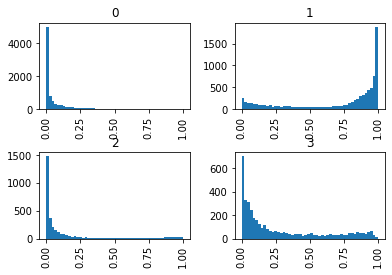

In [18]:
plt.figure(figsize=(16,10))
selection.hist(column='pred_1', by='true_cat_combined', bins=50, range=[0,1])
plt.show()

<Figure size 1152x720 with 0 Axes>

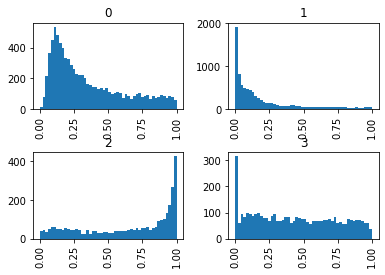

In [20]:
plt.figure(figsize=(16,10))
selection.hist(column='pred_2', by='true_cat_combined', bins=50, range=[0,1])
plt.show()

<Figure size 1152x720 with 0 Axes>

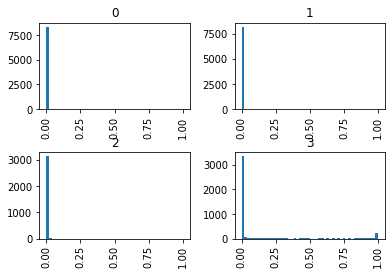

In [22]:
plt.figure(figsize=(16,10))
selection.hist(column='pred_3', by='true_cat_combined', bins=50, range=[0,1])
plt.show()

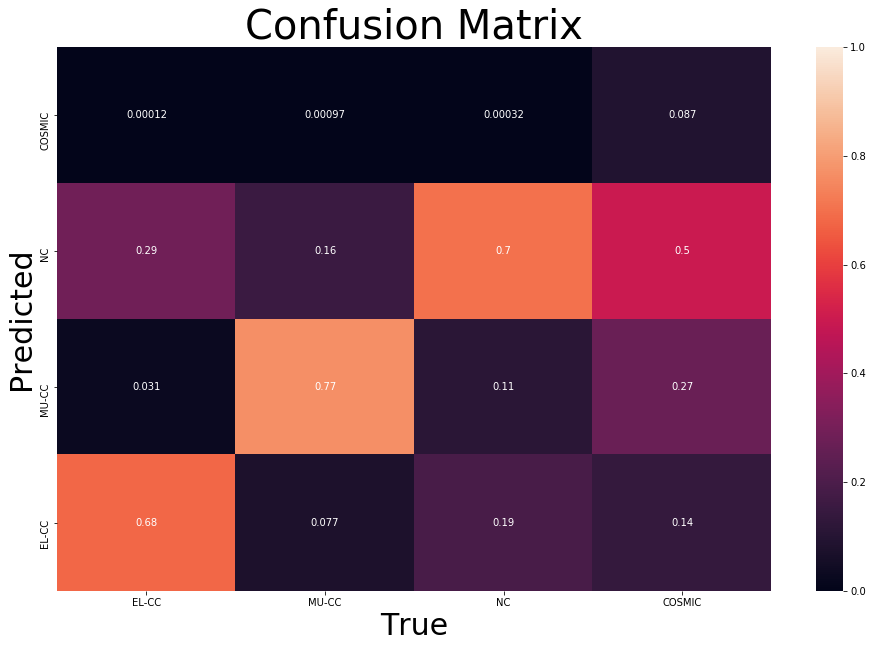

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
matrix = confusion_matrix(selection["true_cat_combined"], selection["pred_cat_combined"], normalize='true')
matrix_transpose = np.rot90(matrix, 1)
df_cm = pd.DataFrame(matrix_transpose, 
                     index = ["COSMIC", "NC", "MU-CC", "EL-CC"],
                     columns = ["EL-CC", "MU-CC", "NC", "COSMIC"])
plt.figure(figsize=(16,10))
sn.heatmap(df_cm, annot=True, vmin=0.0, vmax=1.0)
plt.title('Confusion Matrix', fontsize = 40) # title with fontsize 20
plt.xlabel('True', fontsize = 30) # x-axis label with fontsize 15
plt.ylabel('Predicted', fontsize = 30) # y-axis label with fontsize 15
plt.show()

In [24]:
from sklearn.metrics import classification_report
axis_labels = ["EL-CC", "MU-CC", "NC", "COSMIC"]
print(classification_report(selection["true_cat_combined"], selection["pred_cat_combined"], target_names=axis_labels))

              precision    recall  f1-score   support

       EL-CC       0.76      0.68      0.72      8334
       MU-CC       0.79      0.77      0.78      8246
          NC       0.28      0.70      0.40      3134
      COSMIC       0.97      0.09      0.16      3909

    accuracy                           0.62     23623
   macro avg       0.70      0.56      0.51     23623
weighted avg       0.74      0.62      0.60     23623



In [38]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca_result = pca.fit_transform(np.stack(evaluator.events["dense_output"], axis=0))
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.24028741 0.17856097 0.14371489]


In [41]:
# Add in the labels
pca_df = pd.DataFrame(pca_result)
pca_df['true_cat_combined'] = evaluator.events['true_cat_combined']
pca_df.rename(columns={0: "PCA1", 1: "PCA2", 2: "PCA3"}, inplace=True)
pca_df.head()

,PCA1,PCA2,PCA3,true_cat_combined
0,-5.476081,11.866650,-12.577116,1
1,5.749567,-6.511780,3.681557,0
2,-5.422697,15.057068,-2.909342,1
3,-4.708232,-6.219254,3.114709,3
4,-10.045213,-13.058044,-1.029434,3


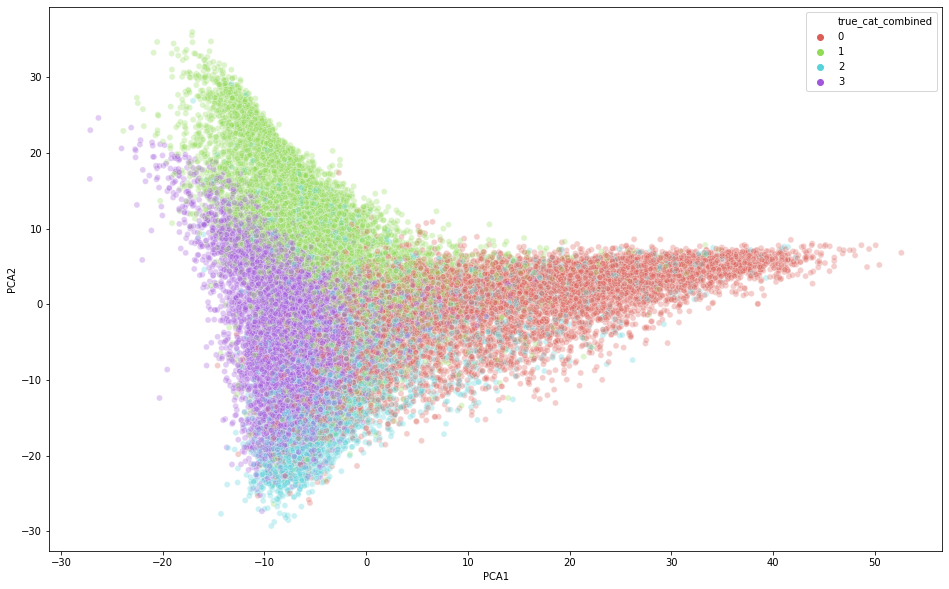

In [42]:
import seaborn as sns
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="PCA1", y="PCA2",
    hue="true_cat_combined",
    palette=sns.color_palette("hls", 4),
    data=pca_df,
    legend="full",
    alpha=0.3
)
plt.show()

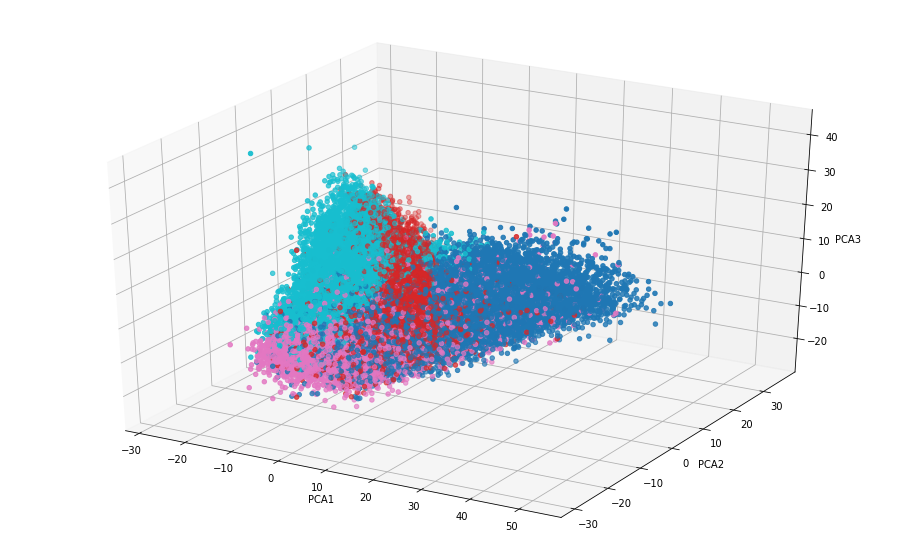

In [43]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=pca_df["PCA1"], 
    ys=pca_df["PCA2"], 
    zs=pca_df["PCA3"], 
    c=pca_df["true_cat_combined"], 
    cmap='tab10'
)
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
plt.show()

In [44]:
N = 10000
events_subset = evaluator.events[:N]

In [45]:
import time
from sklearn.manifold import TSNE
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(np.stack(events_subset["dense_output"], axis=0))
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.882s...
[t-SNE] Computed neighbors for 10000 samples in 61.614s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 4.347046
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.613007
[t-SNE] KL divergence after 300 iterations: 2.668119
t-SNE done! Time elapsed

In [47]:
tsne_df = pd.DataFrame(tsne_results)
tsne_df['true_cat_combined'] = events_subset['true_cat_combined']
tsne_df.rename(columns={0: "tsne-2d-one", 1: "tsne-2d-two"}, inplace=True)
tsne_df.head()

,tsne-2d-one,tsne-2d-two,true_cat_combined
0,8.931087,3.687987,1
1,-1.844063,-5.904953,0
2,5.751251,3.389869,1
3,-4.297797,0.815751,3
4,-9.135437,-0.595514,3


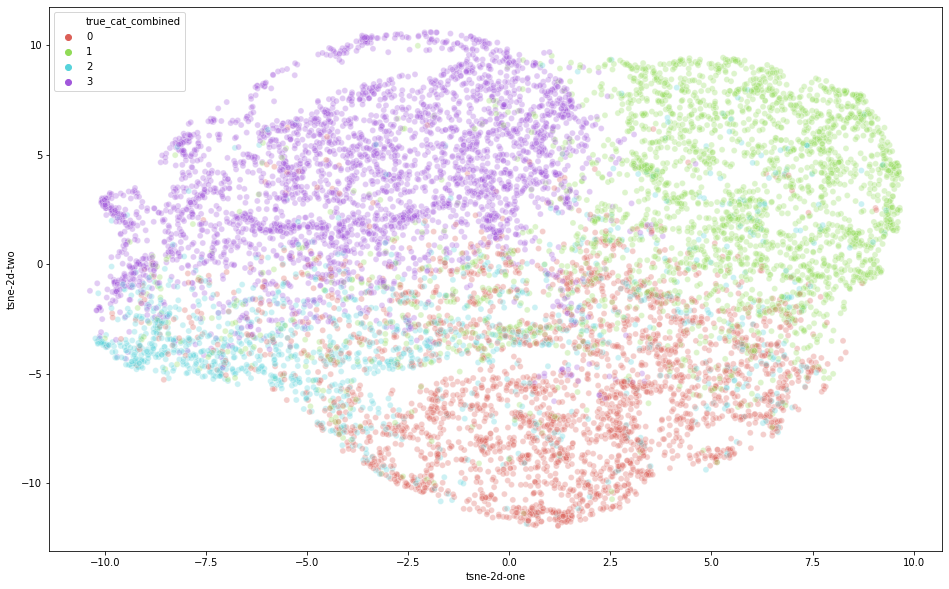

In [48]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="true_cat_combined",
    palette=sns.color_palette("hls", 4),
    data=tsne_df,
    legend="full",
    alpha=0.3
)

In [49]:
pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(np.stack(evaluator.events["dense_output"], axis=0))
print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))
pca_50_df = pd.DataFrame(pca_result_50)
pca_50_df.head()

Cumulative explained variation for 50 principal components: 0.9676449298858643


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-5.476147,11.866720,-12.577073,8.884173,-4.514701,-1.827605,5.394989,-2.629276,1.296695,-1.839228,...,0.761504,1.027998,-0.670540,-1.308436,1.434535,0.523600,-0.974359,1.029448,-1.711239,1.040358
1,5.749596,-6.511990,3.681551,3.839672,-2.690220,-0.547649,2.582445,1.238807,-0.547343,-2.250917,...,0.867752,0.056384,-0.055531,-0.177715,-0.569662,-0.329017,0.078712,-0.346047,0.483235,-0.494209
2,-5.422697,15.057104,-2.909550,-1.409032,-2.778925,-1.284130,1.324327,3.130326,-0.860348,0.559946,...,-1.250469,1.414049,-0.323679,0.274521,0.350446,-0.825326,-1.399700,0.385887,0.188651,-0.339070
3,-4.708228,-6.219267,3.114685,0.707712,-3.250485,-1.276483,1.605605,-2.848272,-0.564116,-1.337172,...,0.025356,0.057894,0.041587,-0.587919,-0.254721,0.307232,-0.149205,-0.392112,0.145969,-0.007909
4,-10.045210,-13.058058,-1.029453,11.133355,-0.443350,-0.524239,-1.800295,0.499048,-5.709527,3.281100,...,-0.715622,-0.402013,0.506200,-0.535896,-0.119766,0.919141,0.681522,0.355417,-0.432582,-0.414716


In [46]:
N = 10000
pca_50_subset = evaluator[:N]
labels_50_subset = evaluator.labels[:N]

In [ ]:
tsne = TSNE(n_components=2, verbose=1, perplexity=100, n_iter=1000, learning_rate=1000.0, early_exaggeration=12.0)
tsne_results_50 = tsne.fit_transform(pca_50_subset)

tsne_50_df = pd.DataFrame(tsne_results_50)
tsne_50_df['category_combined'] = labels_50_subset['category_combined']
tsne_50_df.rename(columns={0: "tsne-2d-one", 1: "tsne-2d-two"}, inplace=True)

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="category_combined",
    palette=sns.color_palette("hls", 4),
    data=tsne_50_df,
    legend="full",
    alpha=0.3
)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.138s...


In [ ]:
'''
pi_on_180 = 0.017453292519943295
z_cut = tf.math.less_equal(tf.math.abs(reco_pars_f[6]), self.config.data.cuts.fiducial_z)
r_cut = tf.math.less_equal(
    tf.math.sqrt(tf.math.pow(reco_pars_f[4], 2) + tf.math.pow(reco_pars_f[5], 2)),
    self.config.data.cuts.fiducial_r
)
dir_cut = tf.math.greater_equal(tf.math.multiply(
    tf.math.sin(tf.math.acos(reco_pars_f[7])), tf.math.cos(reco_pars_f[8] * pi_on_180)),
    self.config.data.cuts.dir_x
)
q_cut = tf.math.greater_equal(reco_pars_f[0], self.config.data.cuts.total_q)

import ROOT
from root_numpy import fill_hist
import pandas as pd
%jsroot on

h = ROOT.TH1F("pred_0","pred_0",50,0,1)
h.GetXaxis().SetTitle("Cat 0");
h.GetYaxis().SetTitle("Frequency");
fill_hist(h, array)
c = ROOT.TCanvas("resolution_c","resolution",800,600)
h.Draw()
c.Draw()
'''